In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt

# Đường dẫn đến file Excel
file_path = '\\Nhóm 8 - Thứ 7\\Source Code và Excel\\KNN\\KNN_Dataset_Refined.xlsx'

# Đọc dữ liệu từ file Excel
excel_data = pd.ExcelFile(file_path)

# Đọc các sheet "Training", "Scoring", và "Data" thành DataFrame
training_df = excel_data.parse('Training')
Scoring_df = excel_data.parse('Scoring')
data_df = excel_data.parse('Data')

In [2]:
# --- KNN THỦ CÔNG ---
def knn_manual(training_df, data_df, Scoring_df):
    start_time = time.time()
    
    # Hàm chuẩn hóa dữ liệu
    def normalize(column):
        min_val = column.min()
        max_val = column.max()
        return 100 / (max_val - min_val) * (column - min_val)

    # Chuẩn hóa dữ liệu
    training_df['Normalized Age'] = normalize(training_df['Age'])
    training_df['Normalized Income'] = normalize(training_df['Income (1000s)'])
    training_df['Normalized Cards'] = normalize(training_df['Cards'])

    data_df['Normalized Age'] = normalize(data_df['Age'])
    data_df['Normalized Income'] = normalize(data_df['Income (1000s)'])
    data_df['Normalized Cards'] = normalize(data_df['Cards'])

    # Hàm tính khoảng cách Euclidean chuẩn hóa
    def calculate_normalized_distance(row, data_point):
        return np.sqrt(
            (row['Normalized Age'] - data_point['Normalized Age'])**2 +
            (row['Normalized Income'] - data_point['Normalized Income'])**2 +
            (row['Normalized Cards'] - data_point['Normalized Cards'])**2
        )

    # Dự đoán cho từng dòng dữ liệu
    data_df['Nhan'] = ''
    for data_index, data_point in data_df.iterrows():
        training_df['distance'] = training_df.apply(
            lambda row: calculate_normalized_distance(row, data_point), axis=1
        )
        votes = []
        for _, scoring_row in Scoring_df.iterrows():
            k = int(scoring_row['K'])
            nearest_neighbors = training_df.nsmallest(k, 'distance')
            votes += list(nearest_neighbors['Response'])
        predicted_label = max(set(votes), key=votes.count)
        data_df.at[data_index, 'Nhan'] = predicted_label

    # Tính độ chính xác
    correct_predictions = (data_df['Nhan'] == data_df['Response (Thực Tế)']).sum()
    total_predictions = len(data_df)
    accuracy = correct_predictions / total_predictions
    
    manual_time = time.time() - start_time
    return manual_time, accuracy
    

In [3]:
# --- KNN THƯ VIỆN ---
def knn_library(training_df, data_df, Scoring_df):
    start_time = time.time()
    
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 100))
    training_df[['Normalized Age', 'Normalized Income', 'Normalized Cards']] = scaler.fit_transform(
        training_df[['Age', 'Income (1000s)', 'Cards']]
    )
    data_df[['Normalized Age', 'Normalized Income', 'Normalized Cards']] = scaler.transform(
        data_df[['Age', 'Income (1000s)', 'Cards']]
    )

    X_train = training_df[['Normalized Age', 'Normalized Income', 'Normalized Cards']]
    y_train = training_df['Response']
    X_data = data_df[['Normalized Age', 'Normalized Income', 'Normalized Cards']]
    
    # Dự đoán cho từng dòng dữ liệu với từng giá trị K
    all_predictions = []
    for _, scoring_row in Scoring_df.iterrows():
        k = int(scoring_row['K'])
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_data)
        all_predictions.append(predictions)

    # Gán nhãn cuối cùng
    data_df['Nhan'] = ''
    for i in range(len(data_df)):
        row_predictions = [pred[i] for pred in all_predictions]
        most_common_label = Counter(row_predictions).most_common(1)[0][0]
        data_df.at[i, 'Nhan'] = most_common_label

    # Tính độ chính xác
    correct_predictions = (data_df['Nhan'] == data_df['Response (Thực Tế)']).sum()
    total_predictions = len(data_df)
    accuracy = correct_predictions / total_predictions

    library_time = time.time() - start_time
    return library_time, accuracy

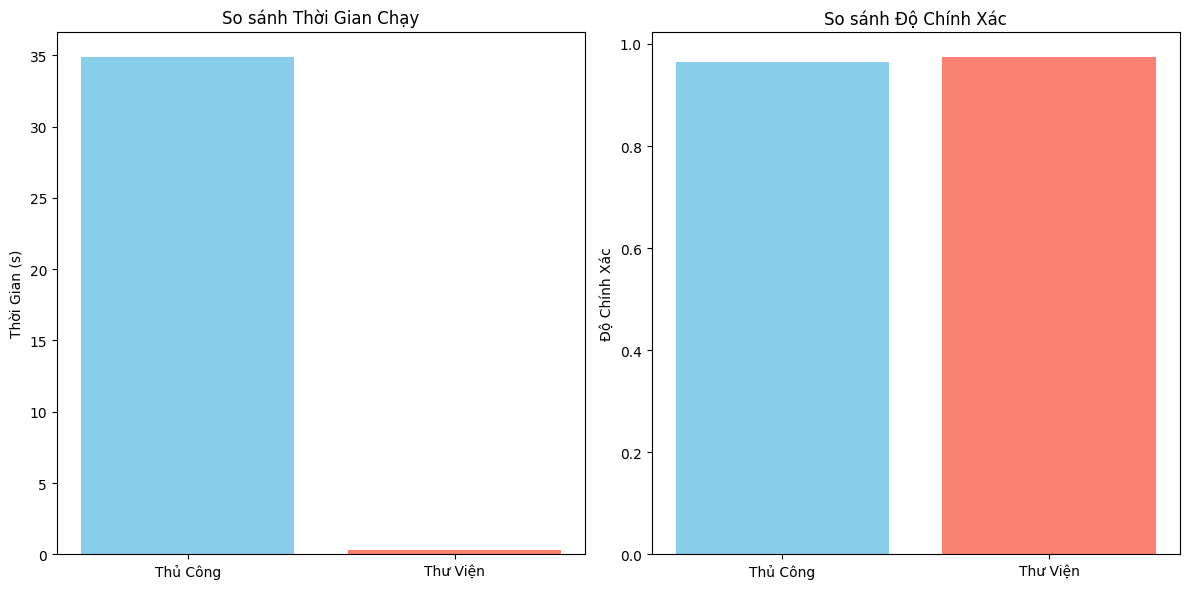

Thời gian chạy của phương pháp Thủ công: 34.8946 giây
Độ chính xác của phương pháp Thủ công: 96.50%
Thời gian chạy của phương pháp Thư viện: 0.3252 giây
Độ chính xác của phương pháp Thư viện: 97.50%


In [4]:
# Chạy cả 2 phương pháp
manual_time, manual_accuracy = knn_manual(training_df.copy(), data_df.copy(), Scoring_df)
library_time, library_accuracy = knn_library(training_df.copy(), data_df.copy(), Scoring_df)

# --- Vẽ Biểu Đồ ---
# So sánh thời gian
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
methods = ['Thủ Công', 'Thư Viện']
times = [manual_time, library_time]
plt.bar(methods, times, color=['skyblue', 'salmon'])
plt.title('So sánh Thời Gian Chạy')
plt.ylabel('Thời Gian (s)')

# So sánh độ chính xác
plt.subplot(1, 2, 2)
accuracies = [manual_accuracy, library_accuracy]
plt.bar(methods, accuracies, color=['skyblue', 'salmon'])
plt.title('So sánh Độ Chính Xác')
plt.ylabel('Độ Chính Xác')

plt.tight_layout()
plt.show()

# Hiển thị độ chính xác và thời gian chạy của mỗi phương pháp
print(f"Thời gian chạy của phương pháp Thủ công: {manual_time:.4f} giây")
print(f"Độ chính xác của phương pháp Thủ công: {manual_accuracy * 100:.2f}%")
print(f"Thời gian chạy của phương pháp Thư viện: {library_time:.4f} giây")
print(f"Độ chính xác của phương pháp Thư viện: {library_accuracy * 100:.2f}%")